In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
conf = SparkConf().set("spark.ui.port", "4050")

# creamos el contexto y la sesión
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/28 03:23:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/28 03:23:35 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


In [3]:
spark

### Retomemos el ejemplo de los trabajos de Shakespeare pero ahora usando Spark:

In [4]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# id='1SE6k_0YukzGd5wK-E4i6mG83nydlfvSa'
# downloaded = drive.CreateFile({'id': id})
# downloaded.GetContentFile('pg100.txt')

### Leemos el archivo `pg100.txt` y creamos un RDD usando SparkContext:

In [4]:
pg100 = sc.textFile('./data/pg100.txt')

###**Para la casa:**  Entender la diferencia entre SparkContext y SparkSession

In [5]:
pg100.take(10)

['The Project Gutenberg EBook of The Complete Works of William Shakespeare, by',
 'William Shakespeare',
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 '',
 '** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **',
 '**     Please follow the copyright guidelines in this file.     **']

In [6]:
type(pg100)

pyspark.rdd.RDD

### Creamos una función que "limpia" cada línea:  se remueven signos de puntuación y otros caracteres.  Adicionalmente convertimos el texto a minúscula

In [7]:
def clean_text(line:str) -> str:
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-'
    lowercased = line.lower()
    return lowercased.translate(str.maketrans('','',punct)).strip()

In [8]:
pg100 = pg100.map(clean_text)

In [9]:
type(pg100)

pyspark.rdd.PipelinedRDD

In [10]:
pg100.take(10)

['the project gutenberg ebook of the complete works of william shakespeare by',
 'william shakespeare',
 '',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever  you may copy it give it away or',
 'reuse it under the terms of the project gutenberg license included',
 'with this ebook or online at wwwgutenbergorg',
 '',
 'this is a copyrighted project gutenberg ebook details below',
 'please follow the copyright guidelines in this file']

In [10]:
all_words = pg100.flatMap(lambda line: line.split())

In [11]:
all_words.take(20)

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'complete',
 'works',
 'of',
 'william',
 'shakespeare',
 'by',
 'william',
 'shakespeare',
 'this',
 'ebook',
 'is',
 'for',
 'the',
 'use']

In [12]:
pg100_count = all_words.map(lambda word: (word,1))

In [13]:
pg100_rbk = pg100_count.reduceByKey(lambda a,b: a+b).sortByKey()

In [14]:
pg100_rbk.persist()

PythonRDD[15] at RDD at PythonRDD.scala:53

In [15]:
pg100_rbk.take(10)

[('00', 1),
 ('01', 1),
 ('02', 1),
 ('03', 1),
 ('04', 1),
 ('05', 1),
 ('1', 311),
 ('10', 3),
 ('100', 2),
 ('10000', 2)]

###Truco para encontrar las palabras con mas ocurrencias:

In [16]:
pg100_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(10)

[(27825, 'the'),
 (26791, 'and'),
 (20681, 'i'),
 (19261, 'to'),
 (18289, 'of'),
 (14667, 'a'),
 (13716, 'you'),
 (12481, 'my'),
 (11135, 'that'),
 (11027, 'in')]

In [17]:
import nltk

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

###Dejamos solo las palabras que no sean stopwords:

In [20]:
pg100_rbk = pg100_rbk.filter(lambda tupla: tupla[0] not in stopwords)

In [21]:
pg100_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

[(5485, 'thou'),
 (4032, 'thy'),
 (3593, 'shall'),
 (3178, 'thee'),
 (3059, 'lord'),
 (2861, 'king'),
 (2812, 'good'),
 (2754, 'sir'),
 (2508, 'come'),
 (2462, 'well'),
 (2295, 'would'),
 (2099, 'let'),
 (2098, 'enter'),
 (2053, 'love'),
 (1972, 'ill'),
 (1941, 'hath'),
 (1880, 'may'),
 (1835, 'man'),
 (1781, 'one'),
 (1733, 'go')]

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [23]:
word_dict = {tupla[0]:float(tupla[1]) for tupla in pg100_rbk.collect()}

In [24]:
wc = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict)

(-0.5, 2999.5, 999.5, -0.5)

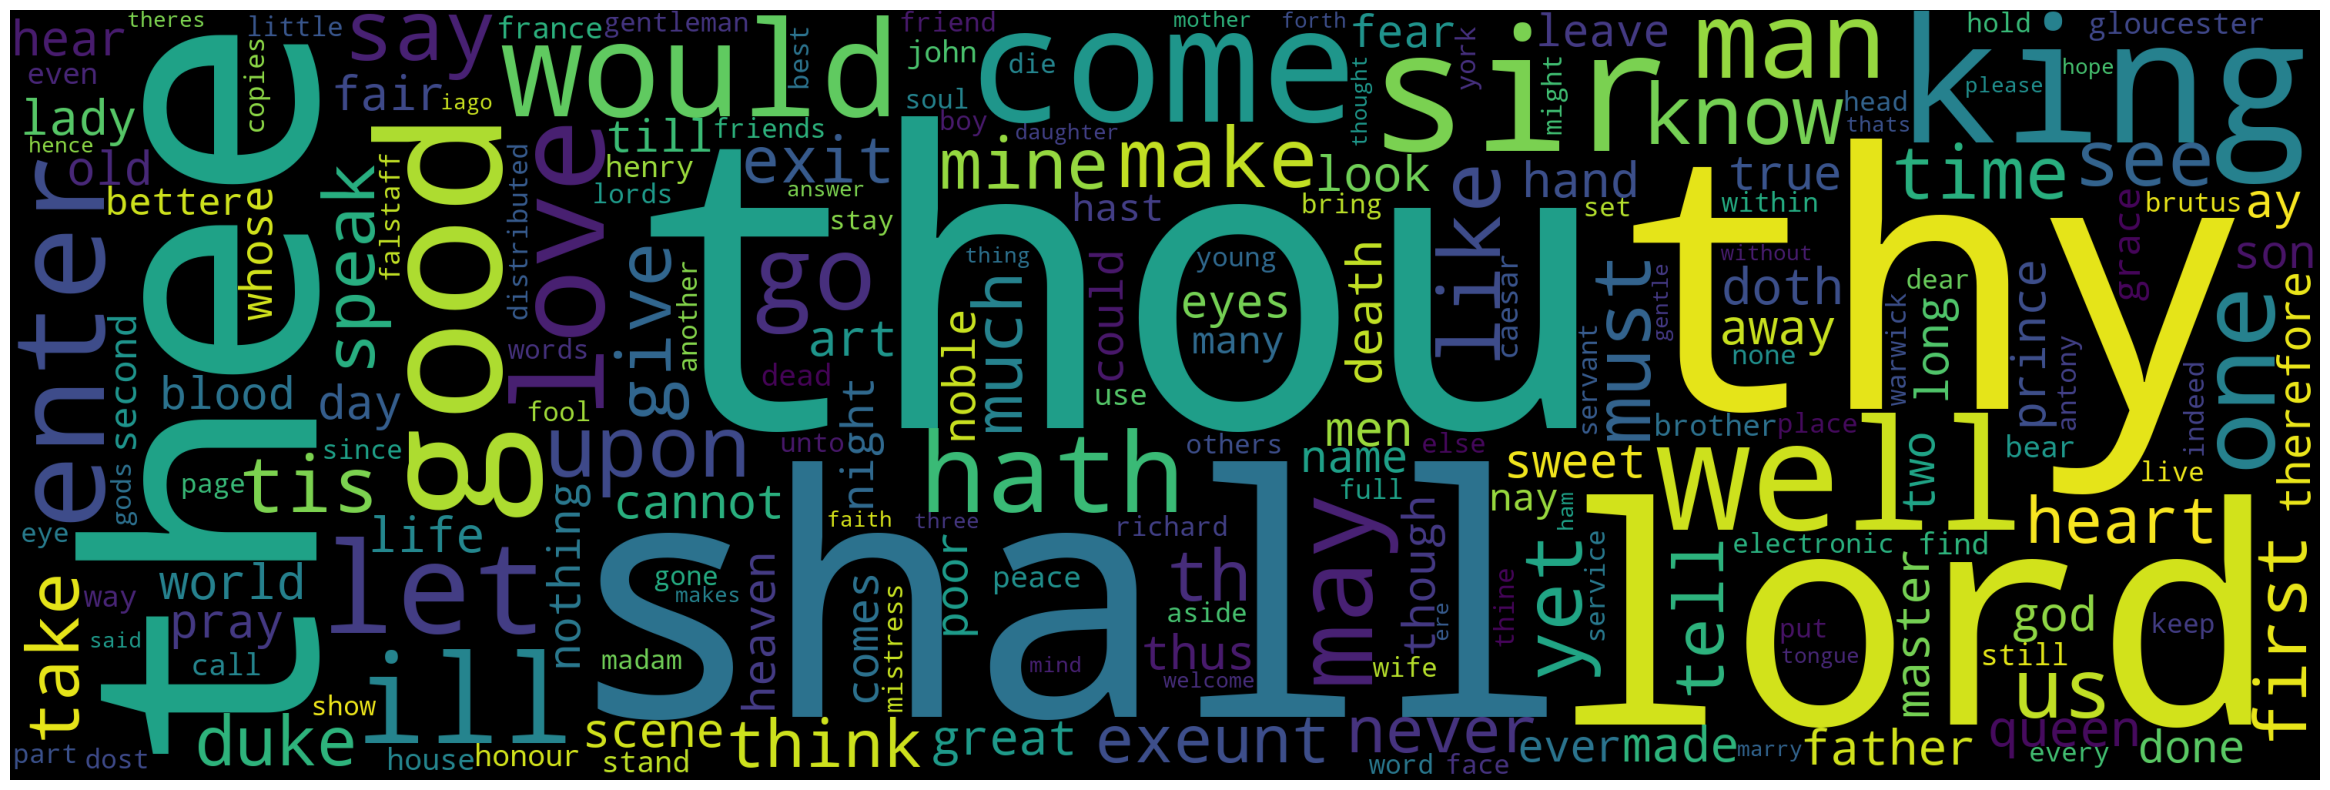

In [25]:
plt.figure(figsize=(30, 10))
plt.imshow(wc)
plt.axis("off")